![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    XGBoost gap-filling
</b>: Minimal example    
</span>

---
**Notebook version**: `1` (26 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using [XGBoost](https://xgboost.readthedocs.io/en/stable/) to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.75.0


</br>

# **Docstring** for `XGBoostTS`

In [3]:
# help(XGBoostTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.043 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085449
VAR,37.032694
SD/MEAN,-1.58743


L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


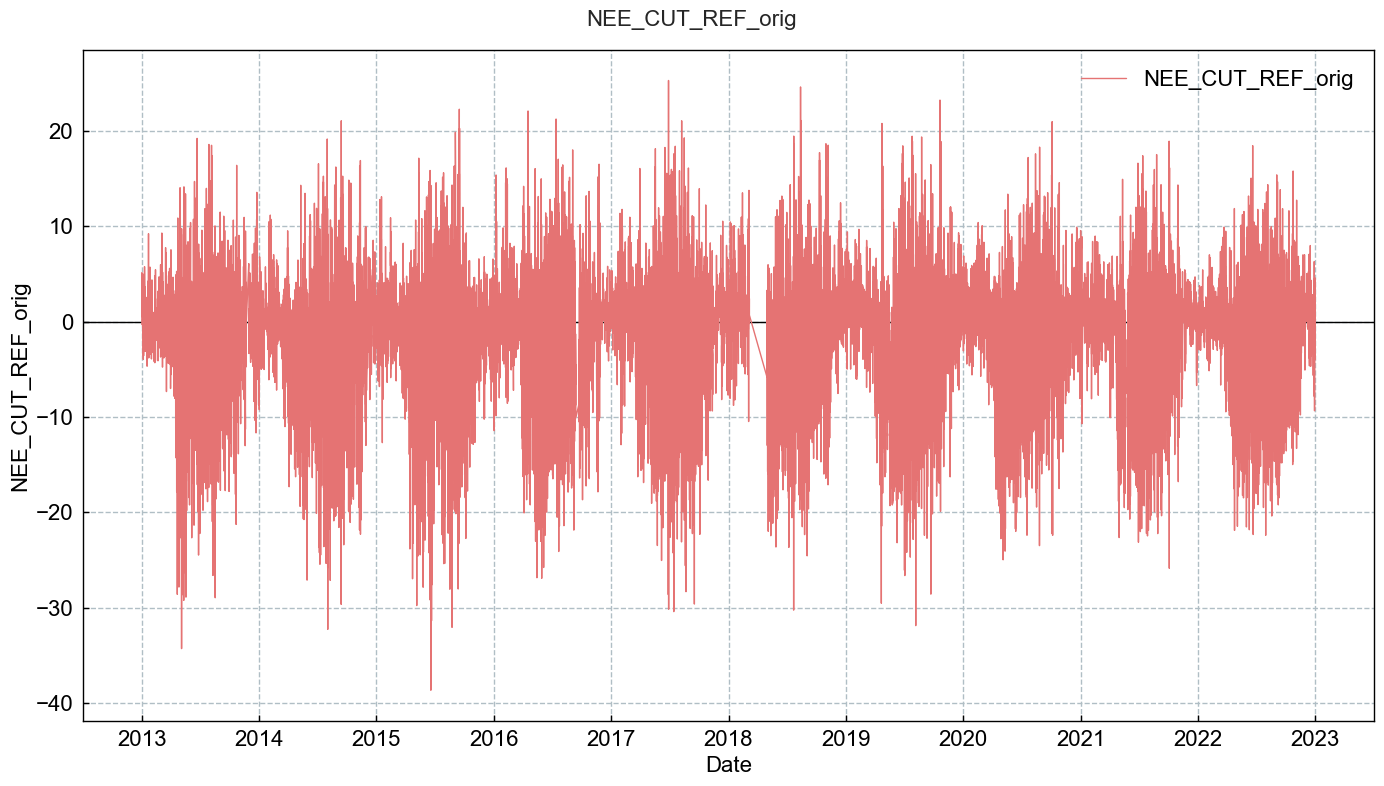

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize XGBoost

In [9]:
xgbts = XGBoostTS(
        input_df=df,
        target_col=TARGET_COL,                    
        n_estimators=99,        
        random_state=42,  # To keep results consitent between runs
        n_jobs=-1  # Use all available CPU cores
    )

</br>

## Feature reduction

In [10]:
xgbts.reduce_features()



Feature reduction based on permutation importance ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:5.01045	validation_1-rmse:5.06030
[1]	validation_0-rmse:4.35827	validation_1-rmse:4.42919
[2]	validation_0-rmse:3.98184	validation_1-rmse:4.06488
[3]	validation_0-rmse:3.76197	validation_1-rmse:3.85593
[4]	validation_0-rmse:3.63649	validation_1-rmse:3.73628
[5]	validation_0-rmse:3.57002	validation_1-rmse:3.67734
[6]	validation_0-rmse:3.52062	validation_1-rmse:3.63871
[7]	validation_0-rmse:3.49164	validation_1-rmse:3.61759
[8]	validation_0-rmse:3.46882	validation_1-rmse:3.60305
[9]	validation_0-rmse:3.45453	validation_1-rmse:3.59754
[10]	validation_0-rmse:3.44440	validation_1-rmse:3.59588
[11]	validation_0-rmse:3.43348	validation_1-rmse:3.59616
[12]	validation_0-rmse:3.42354	validation_1-rmse:3.59301
[13]	validation_0-rmse:3.41611	validation_1-rmse:3.59417
[14]	validation_0-rmse:3.40927	validation_1-rmse:3.59429
[15]	validation_0-rmse:3.40234	validation_

In [11]:
xgbts.report_feature_reduction()


FEATURE REDUCTION

- the random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances
- target variable: NEE_CUT_REF_orig
- features before reduction: ['Rg_f', 'Tair_f', 'VPD_f', '.RANDOM']
- permutation importance was calculated from 3 permutations
- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.


PERMUTATION IMPORTANCE (FULL RESULTS):

         PERM_IMPORTANCE   PERM_SD
Rg_f            1.396775  0.015523
Tair_f          1.057946  0.011651
VPD_f           0.548097  0.005102
.RANDOM        -0.001863  0.000540

--> 4 input features, including .RANDOM: ['Rg_f', 'Tair_f', 'VPD_f', '.RANDOM']
--> 3 accepted features, larger than .RANDOM: ['Rg_f', 'Tair_f', 'VPD_f']
--> 1 rejected features, smaller than or equal to .RANDOM: ['.RANDOM']



</br>

## Train model

Building <class 'xgboost.sklearn.XGBRegressor'> model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:5.01085	validation_1-rmse:5.05899
[1]	validation_0-rmse:4.35924	validation_1-rmse:4.42779
[2]	validation_0-rmse:3.98348	validation_1-rmse:4.06293
[3]	validation_0-rmse:3.76395	validation_1-rmse:3.85240
[4]	validation_0-rmse:3.63988	validation_1-rmse:3.73152
[5]	validation_0-rmse:3.57302	validation_1-rmse:3.67123
[6]	validation_0-rmse:3.52490	validation_1-rmse:3.63135
[7]	validation_0-rmse:3.49683	validation_1-rmse:3.61086
[8]	validation_0-rmse:3.47750	validation_1-rmse:3.59560
[9]	validation_0-rmse:3.46305	validation_1-rmse:3.58741
[10]	validation_0-rmse:3.45501	validation_1-rmse:3.58390
[11]	validation_0-rmse:3.44491	validation_1-rmse:3.57961
[12]	validation_0-rmse:3.44131	validation_1-rmse:3.57934
[13]	validation_0-rmse:3.43360	validation_1-rmse:3.57964
[14]	validation_0-rmse:3.42856	

L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


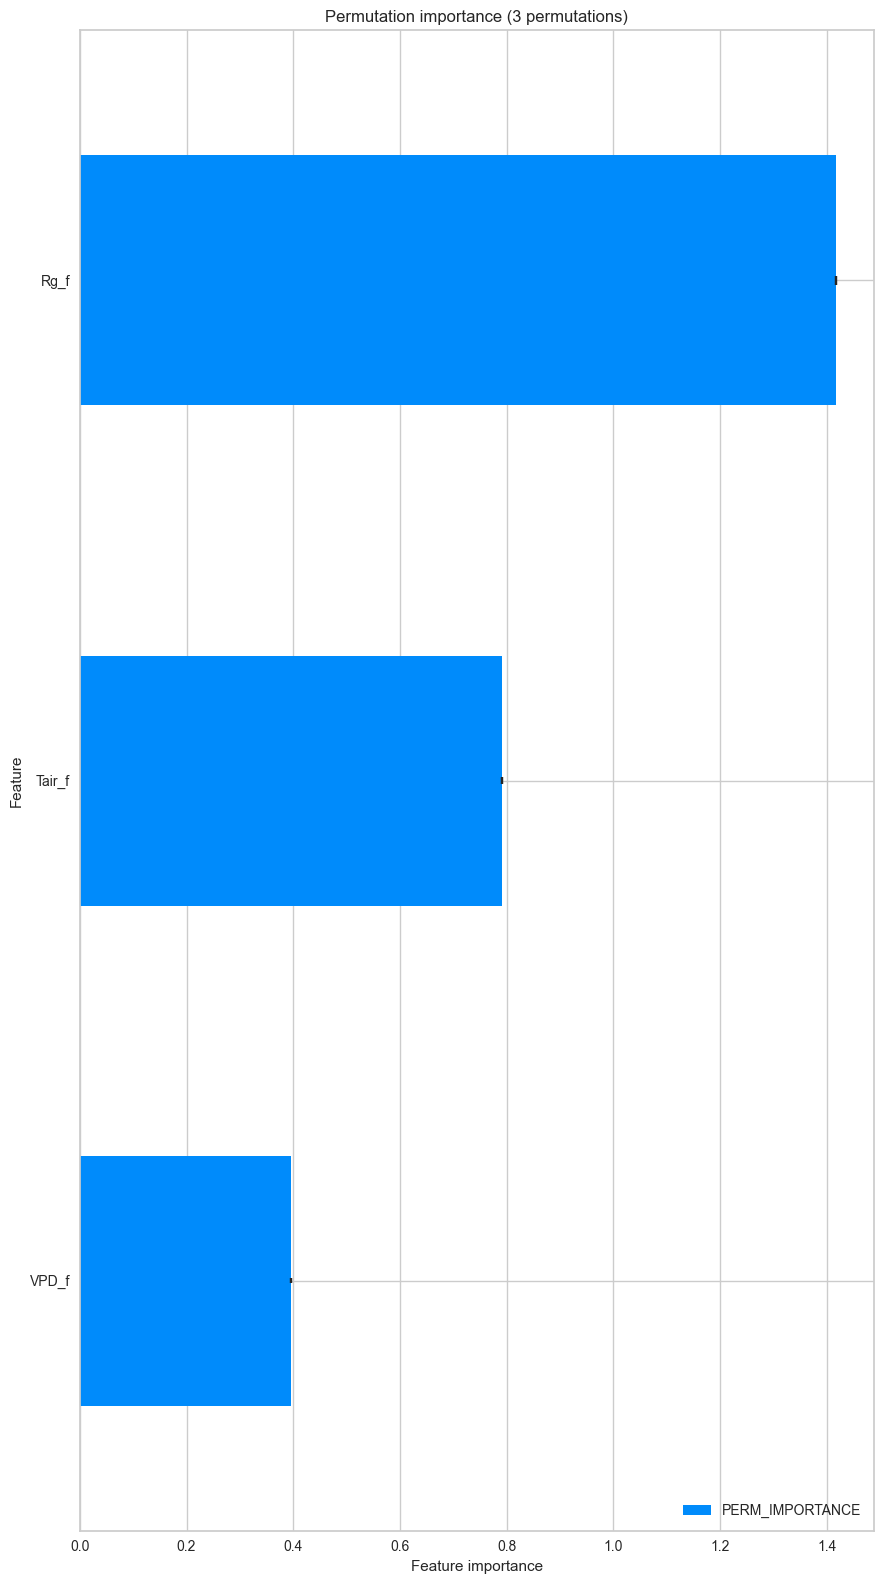

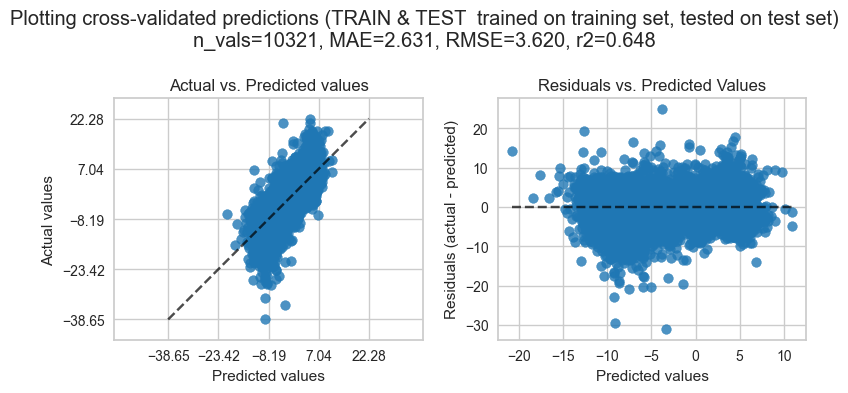

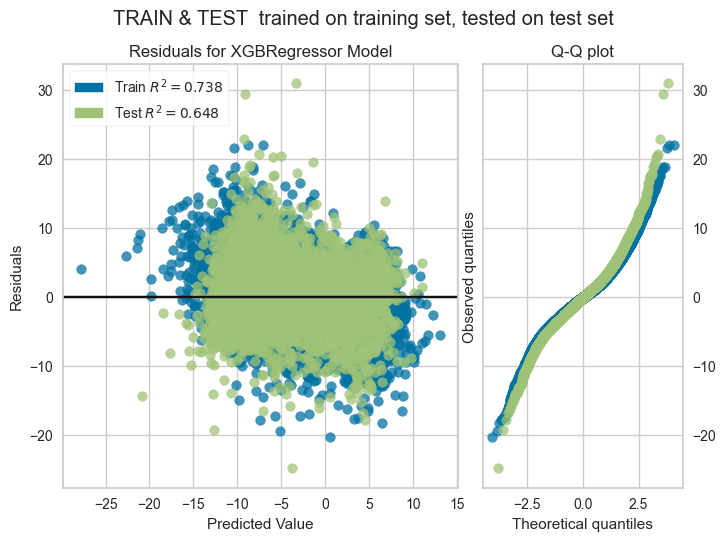

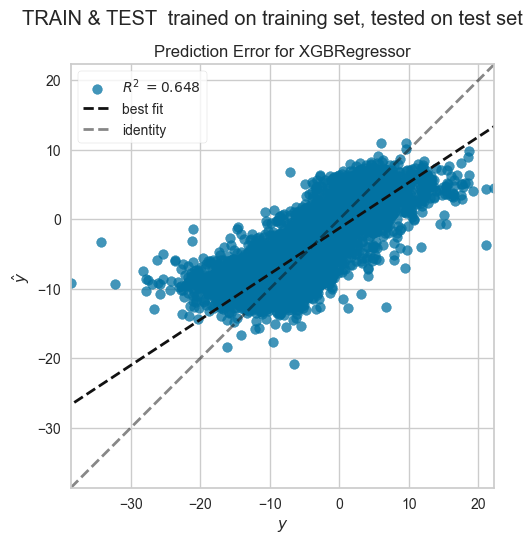

In [12]:
xgbts.trainmodel(showplot_scores=True, showplot_importance=True)

In [13]:
xgbts.report_traintest()


MODEL TRAINING & TESTING RESULTS

- the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
- in total, 41284 observed target values were available for training and testing
- the dataset was split into training and test datasets
  > the training dataset comprised 30963 target values (75.0%)
  > the test dataset comprised 10321 target values (25.0%)

## FEATURE IMPORTANCES
- feature importances were calculated for test data (10321 target values).
- permutation importances were calculated from 3 repeats.
        PERM_IMPORTANCE   PERM_SD
Rg_f           1.417461  0.008945
Tair_f         0.791058  0.007621
VPD_f          0.395501  0.005402

## MODEL
The model was trained on the training set.
- estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categor

</br>

## Apply model to fill gaps

Calculating permutation importance using model <class 'xgboost.sklearn.XGBRegressor'> ...


L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


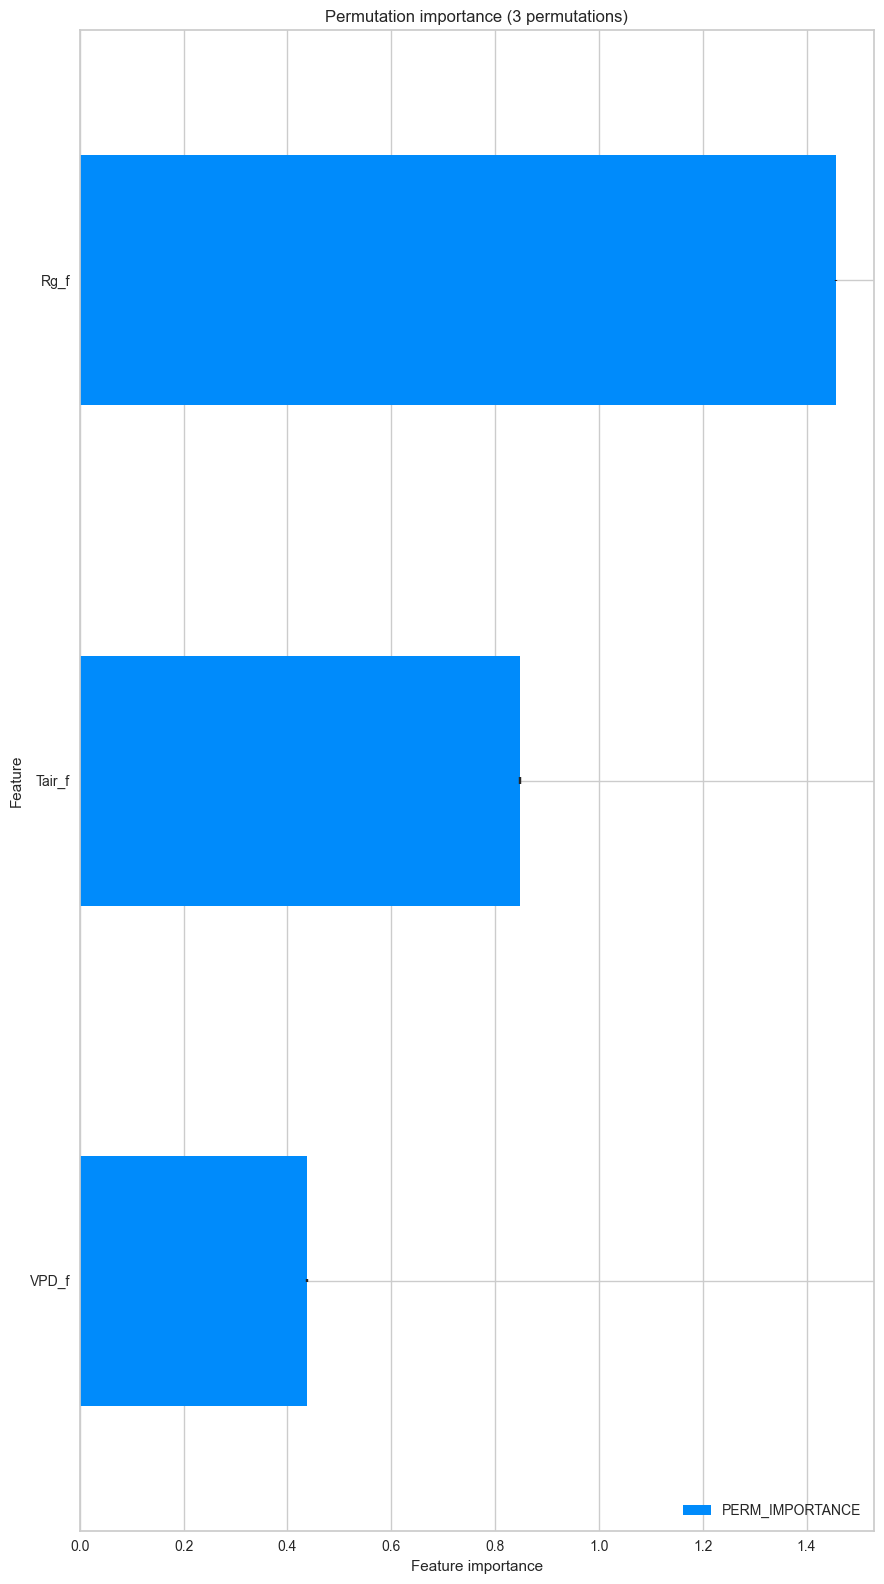

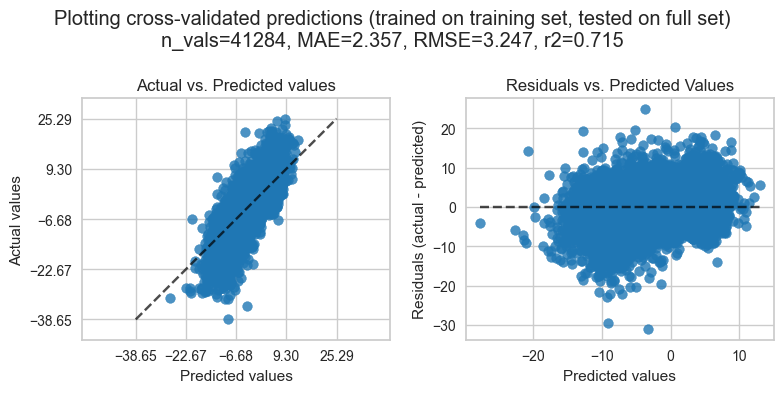

In [14]:
xgbts.fillgaps(showplot_scores=True, showplot_importance=True)

In [15]:
xgbts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134012 values, NEE_CUT_REF_orig_gfXG where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfXG  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134012 values)
  > flag 2 ... targets gap-filled with fallback (0 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', 'Tair_f', 'VPD_f']
- number of features used in model:  3
- permutation importances were c

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [16]:
xgbts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.457146,0.000222
Tair_f,0.848385,0.007304
VPD_f,0.438221,0.002936


In [17]:
xgbts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,0.974075,NaN,0.974075,1,0.974075,None,0.974075,0.974075
2013-01-01 00:45:00,0.974075,NaN,0.974075,1,0.974075,None,1.948151,0.974075
2013-01-01 01:15:00,0.974075,NaN,0.974075,1,0.974075,None,2.922226,0.974075
2013-01-01 01:45:00,0.974075,0.538,NaN,0,0.538000,None,3.460226,0.974075
2013-01-01 02:15:00,1.435770,NaN,1.435770,1,1.435770,None,4.895996,1.435770
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.289599,NaN,2.289599,1,2.289599,None,-77640.183256,2.289599
2022-12-31 22:15:00,2.825619,3.518,NaN,0,3.518000,None,-77636.665256,2.825619
2022-12-31 22:45:00,3.202299,NaN,3.202299,1,3.202299,None,-77633.462957,3.202299


In [18]:
xgbts.model_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
xgbts.accepted_features_

['Rg_f', 'Tair_f', 'VPD_f']

In [20]:
xgbts.rejected_features_

['.RANDOM']

In [21]:
xgbts.scores_

{'mae': 2.357199294427239,
 'medae': 1.7542474763393403,
 'mse': 10.541710864068556,
 'rmse': 3.246800096105172,
 'mape': 197936615793.6807,
 'maxe': 30.963097227096554,
 'r2': 0.7153335328230823}

</br>

## Result

In [22]:
gapfilled = xgbts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.974075
2013-01-01 00:45:00    0.974075
2013-01-01 01:15:00    0.974075
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00    1.435770
                         ...   
2022-12-31 21:45:00    2.289599
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    3.202299
2022-12-31 23:15:00    2.797740
2022-12-31 23:45:00    2.811922
Freq: 30min, Name: NEE_CUT_REF_orig_gfXG, Length: 175296, dtype: float64

In [23]:
flag = xgbts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1
2013-01-01 00:45:00    1
2013-01-01 01:15:00    1
2013-01-01 01:45:00    0
2013-01-01 02:15:00    1
                      ..
2022-12-31 21:45:00    1
2022-12-31 22:15:00    0
2022-12-31 22:45:00    1
2022-12-31 23:15:00    1
2022-12-31 23:45:00    1
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED, Length: 175296, dtype: int32

In [24]:
gapfilling_df = xgbts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,0.974075,NaN,0.974075,1,0.974075,None,0.974075,0.974075
2013-01-01 00:45:00,0.974075,NaN,0.974075,1,0.974075,None,1.948151,0.974075
2013-01-01 01:15:00,0.974075,NaN,0.974075,1,0.974075,None,2.922226,0.974075
2013-01-01 01:45:00,0.974075,0.538,NaN,0,0.538000,None,3.460226,0.974075
2013-01-01 02:15:00,1.435770,NaN,1.435770,1,1.435770,None,4.895996,1.435770
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.289599,NaN,2.289599,1,2.289599,None,-77640.183256,2.289599
2022-12-31 22:15:00,2.825619,3.518,NaN,0,3.518000,None,-77636.665256,2.825619
2022-12-31 22:45:00,3.202299,NaN,3.202299,1,3.202299,None,-77633.462957,3.202299


</br>

## Plot

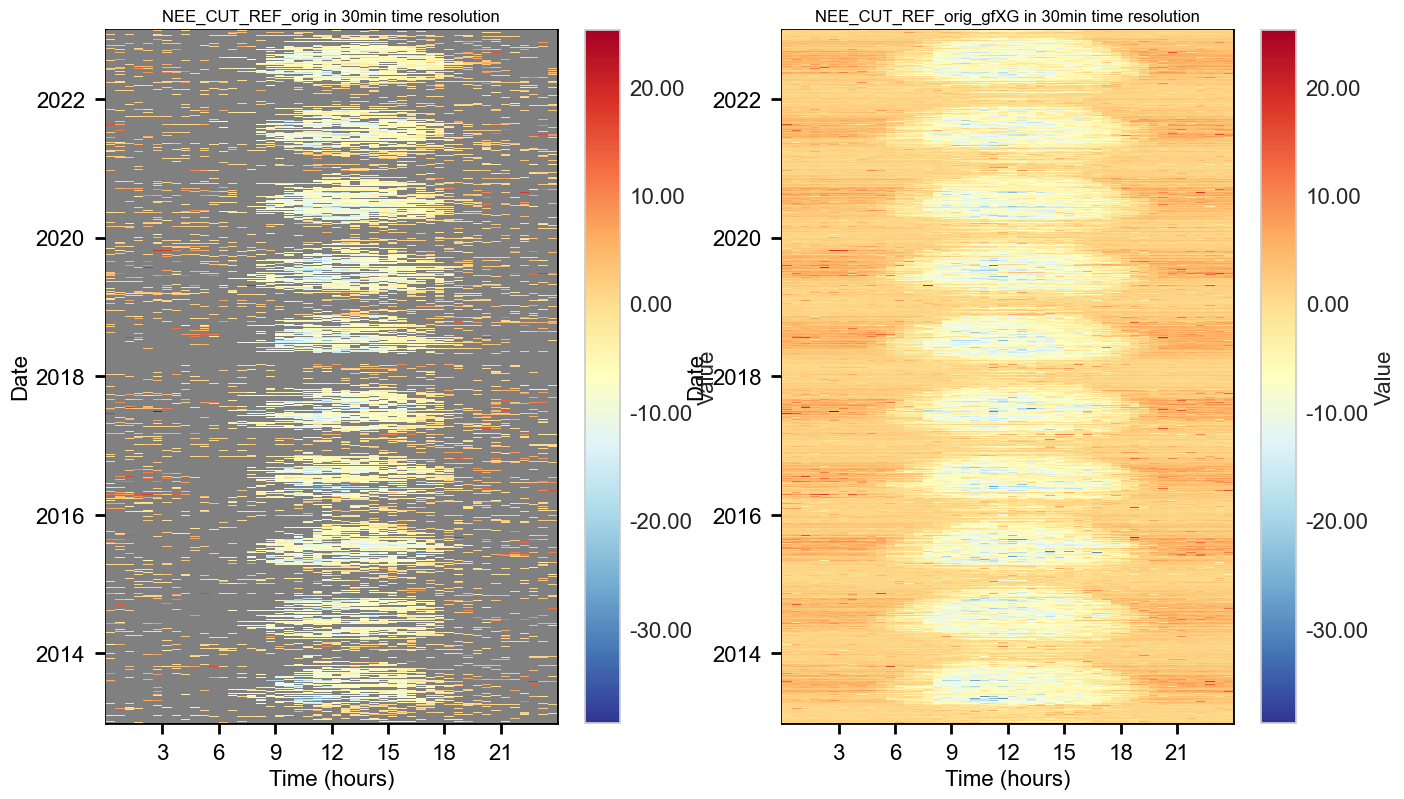

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


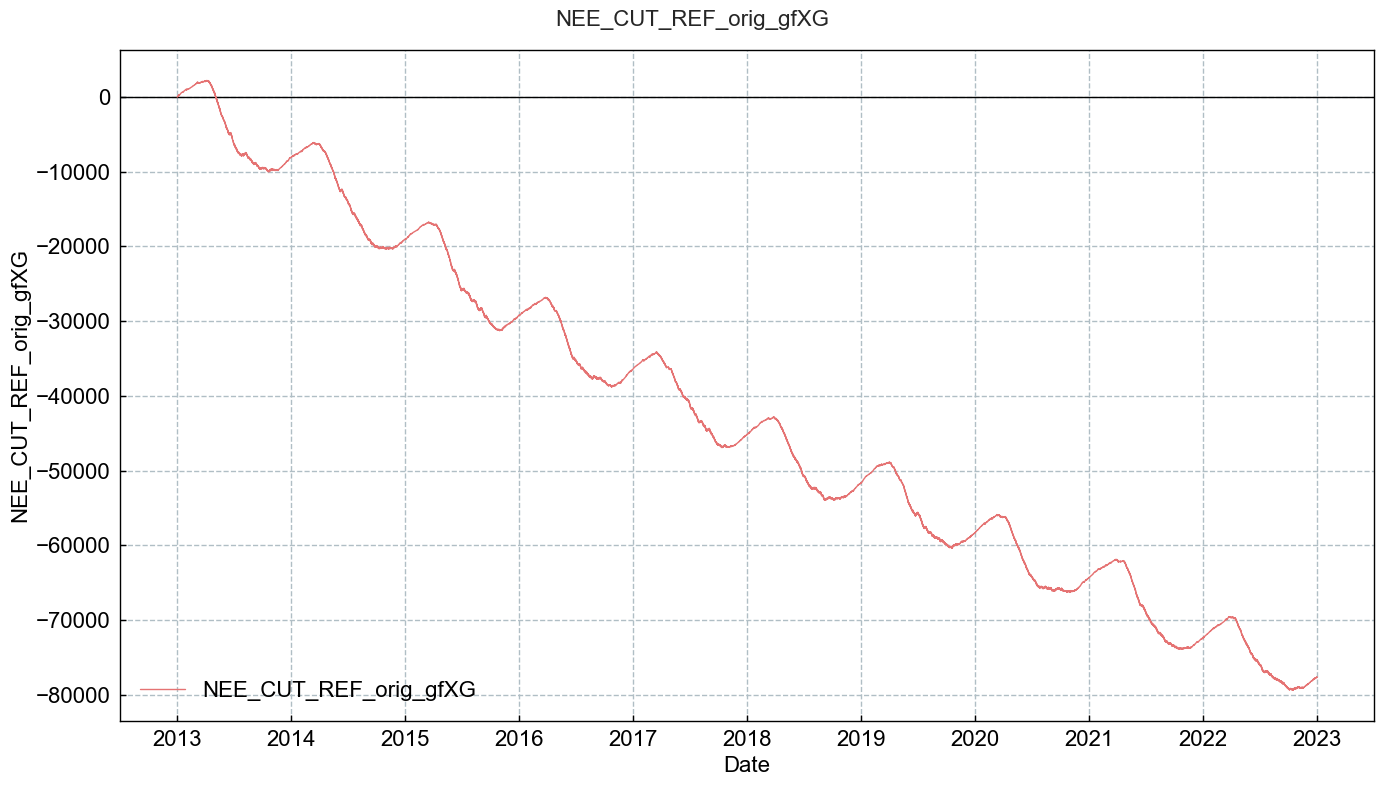

In [26]:
TimeSeries(gapfilled.cumsum()).plot()

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [27]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-26 13:17:51
